## Part 1: Import statements

In [111]:
import numpy as np
import pandas as pd
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from collections import Counter

import tensorflow
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding,GlobalMaxPooling1D, MaxPooling1D, TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution1D as Conv1D, InputLayer, concatenate
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import set_random_seed
from tensorflow.data import Dataset


from gensim.models import Word2Vec

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [112]:
set_random_seed(1)

## Part 2: Importing cleaned data

In [4]:
data = pd.read_csv("Data/processed_data.csv", index_col=0)
data = data.dropna()
data

,tweet,class
0,woman shouldnt complain cleaning house man alw...,2
1,boy dats coldtyga dwn bad cuffin dat hoe place,1
2,dawg ever fuck bitch stato cry confused shit,1
3,look like tranny,1
4,shit hear might true might faker bitch told ya,1
...,...,...
25291,yous muthafin lie right tl trash mine bible sc...,1
25292,youve gone broke wrong heababy drove redneck c...,2
25294,young buck wan na eat dat nigguh like aint fuc...,1
25295,youu got wild bitches tellin lies,1


In [5]:
number_tweets = len(data["tweet"])
print(f"Number of sentences: {number_tweets}")

Number of sentences: 23865


## Part 3: Splitting Data

In [6]:

#splitting the data into train, validation, test
X, X_test, y, y_test = train_test_split(data['tweet'], data['class'],  test_size=0.2, random_state=42)

In [7]:
#splitting the data into train and validation
X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size = 0.25,train_size =0.75, random_state=42)

In [8]:
X_train.sample(5)

13051       man bitch dont call back job cuhh uma snapping
14519    realised library books overdue anyones looking...
10937    like kids beyond scared straight acting like h...
12297                                         winter bitch
18320             somewhere ghetto nigger getting shot bbq
Name: tweet, dtype: object

## Count vectorization

## Oversampling

In [66]:

def oversample(X_train, y_train):
    print("Before Oversampling: {}".format(Counter(y_train)))

    # # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy='all')

    # # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
    print("After Oversampling: {}".format(Counter(y_train_over)))
    
    return X_train_over, y_train_over

In [83]:
#X_train_tk_over, y_train_over = oversample(X_train_tk, y_train)
X_train_over, y_train_over = oversample(np.array(X_train).reshape(-1,1), y_train)

X_train_over = pd.Series(X_train_over.reshape(len(X_train_over)))


Before Oversampling: Counter({1: 11062, 2: 2437, 0: 820})
After Oversampling: Counter({1: 11062, 2: 11062, 0: 11062})


## Tokenization

In [116]:
tokenizer = Tokenizer()

#fitting tokenizer on training set
tokenizer.fit_on_texts(X_train_over)

#encoding training data
encoded_train = tokenizer.texts_to_sequences(X_train_over)
encoded_cv = tokenizer.texts_to_sequences(X_cv)
encoded_test = tokenizer.texts_to_sequences(X_test)

#padding sequences using the maximum sequence of the training set
max_length = max([len(sentence.split()) for sentence in X_train_over])


X_train_tk = pad_sequences(encoded_train,maxlen = max_length, padding = "post" )
X_cv_tk =pad_sequences(encoded_cv,maxlen = max_length, padding = "post" )
X_test_tk =pad_sequences(encoded_test,maxlen = max_length, padding = "post" )

In [117]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

15992

In [119]:
#  encoding target variable
y_train_encoded = to_categorical(y_train_over,3)
y_cv_encoded = to_categorical(y_cv,3)
y_test_encoded = to_categorical(y_test,3)


In [120]:
y_train_encoded

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Print Model statistics

In [88]:
def printModelStats(y_preds, y_test):
    print(classification_report(y_test, y_preds, target_names = ['Hate', 'Offensive', 'Neither']))
   
    cm = confusion_matrix(y_test, y_preds)
    print("The confusion matrix:")
    print(cm)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    sns.heatmap((cm_percent), annot = True, cmap = "Blues").set(title ="Confusion Matrix Expressed in %")

In [89]:
def printResults(history):
    results = pd.DataFrame(history.history)
    return results

In [90]:
def plotLossCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.loss)
    plt.plot(results.index, results.val_loss)
    plt.title("CNN with trained embeddings")
    plt.xlabel("Epochs")
    plt.ylabel("Categorical Crossentropy Loss")
    plt.legend(["Training Loss", "Validation Loss"])
    plt.show()

In [91]:
def plotAccuracyCurves(history):
    results = pd.DataFrame(history.history)
    
    plt.figure(figsize = (10,5))
    plt.plot(results.index, results.accuracy)
    plt.plot(results.index, results.val_accuracy)
    plt.title("CNN with trained embeddings")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy", "Validation Accuracy"])
    plt.show()

## CNN with custom word embedding

Simple 1D Convolutional neural network to capture the sequence of words 
- inspired by: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [237]:
# model1 = Sequential()
# model1.add(Embedding(input_dim= vocab_size, output_dim = 100, input_length = max_length))
# model1.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))
# model1.add(GlobalMaxPooling1D()) #pooling to downsample feature extraction
# model1.add(Flatten())
# model1.add(Dense(64, activation='relu'))
# model1.add(Dense(32, activation='relu'))
# model1.add(Dense(3, activation='softmax'))
# print(model1.summary())


# model1 = Sequential()
# model1.add(Embedding(vocab_size, 100, input_length = max_length))
# model1.add(Conv1D(filters = 128, kernel_size = 5, activation = 'relu'))##filter size 128
# model1.add(MaxPooling1D(pool_size=3)) #pooling to downsample feature extraction
# model1.add(Conv1D(filters = 128, kernel_size = 4, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=3))
# model1.add(Conv1D(filters = 128, kernel_size = 3, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=3))
# model1.add(Flatten())
# model1.add(Dense(10, activation ='relu', kernel_regularizer=l2(0.01))) #weight 0.01
# model1.add(Dropout(0.5))
# model1.add(Dense(3, activation = "softmax"))
# print(model1.summary())

# ****
# model1 = Sequential()
# model1.add(Embedding(vocab_size, 100, input_length = max_length))
# model1.add(Conv1D(filters = 32, kernel_size = 8, activation = 'relu'))
# model1.add(MaxPooling1D(pool_size=2)) #pooling to downsample feature extraction
# model1.add(Flatten())
# model1.add(Dense(10, activation ='relu', kernel_regularizer=l2(0.01)))
# model1.add(Dropout(0.5))
# model1.add(Dense(3, activation = "softmax"))
# model1.summary()

# optimizer = tensorflow.optimizers.Adam(lr=0.0001)
# model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
# callbacks_list = [early_stopping]

# print(model1.summary())


In [95]:
# #Model 1

num_filters = 64
output_dimension = 100
kernel_size = 5


def createCNN1(num_filters=64,kernel_size=8, output_dimension=100):
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [96]:
model1 = createCNN1(num_filters,kernel_size, output_dimension)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_5 (Conv1D)           (None, 123, 64)           32064     
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 61, 64)            0         
 g1D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 3904)              0         
                                                                 
 dense_10 (Dense)            (None, 10)                39050     
                                                           

In [148]:

history = model1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list

#vs batch size 64

Epoch 1/10
519/519 [==============================] - 22s 42ms/step - loss: 0.3503 - accuracy: 0.8905 - val_loss: 0.6668 - val_accuracy: 0.8439
Epoch 2/10
519/519 [==============================] - 24s 46ms/step - loss: 0.3408 - accuracy: 0.8966 - val_loss: 0.7562 - val_accuracy: 0.8412
Epoch 3/10
519/519 [==============================] - 25s 47ms/step - loss: 0.3364 - accuracy: 0.9003 - val_loss: 0.7267 - val_accuracy: 0.8424
Epoch 4/10
519/519 [==============================] - 24s 46ms/step - loss: 0.3288 - accuracy: 0.9045 - val_loss: 0.8334 - val_accuracy: 0.8385
Epoch 4: early stopping


evaluation

In [149]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 4ms/step - loss: 0.8334 - accuracy: 0.8385


In [150]:
printResults(history)

,loss,accuracy,val_loss,val_accuracy
0,0.350254,0.890466,0.666766,0.843914
1,0.340821,0.896613,0.756181,0.841190
2,0.336428,0.900319,0.726714,0.842447
3,0.328782,0.904538,0.833421,0.838466


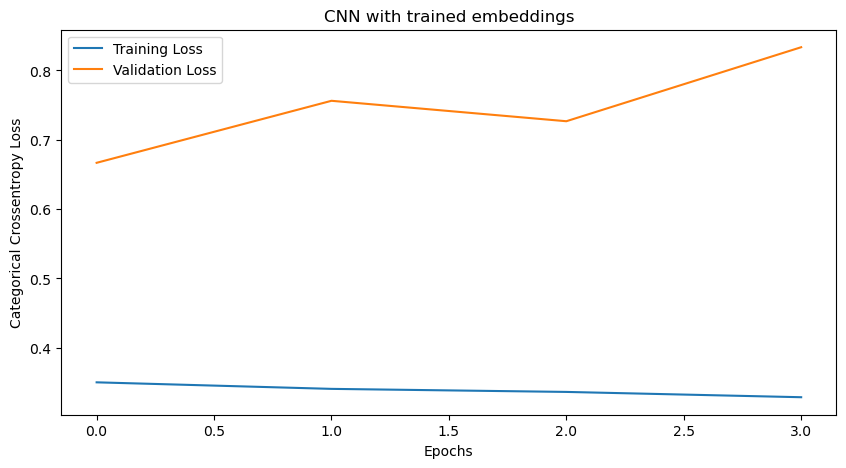

In [151]:
plotLossCurves(history)

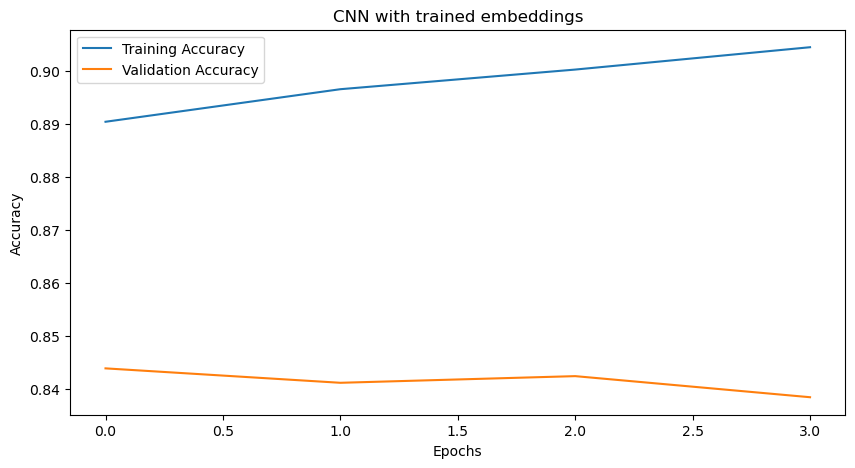

In [152]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

        Hate       0.27      0.29      0.28       269
   Offensive       0.89      0.93      0.91      3670
     Neither       0.80      0.62      0.70       834

    accuracy                           0.84      4773
   macro avg       0.65      0.61      0.63      4773
weighted avg       0.84      0.84      0.84      4773

The confusion matrix:
[[  79  174   16]
 [ 156 3404  110]
 [  61  254  519]]


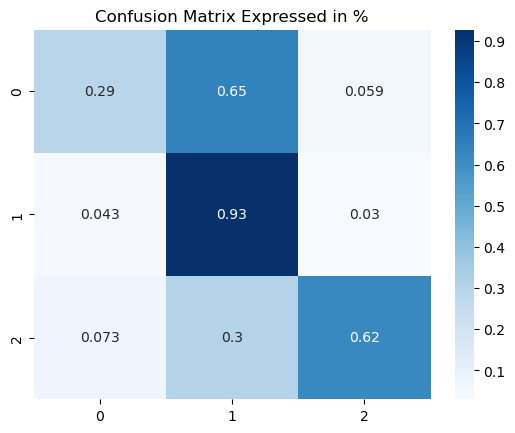

In [153]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

# grid search (normal model)


# then lstm

## Grid Search

In [74]:
from scikeras.wrappers import KerasClassifier
param_grid = {"num_filters" : [32, 64,128],
              "kernel_size" :[3,5,8],
               "output_dimension" : [100,200,300], }


model = KerasClassifier(build_fn=createCNN1,
                            epochs=10,
                           batch_size=64,
                            verbose=False)



In [75]:

search = GridSearchCV(estimator=model, param_grid=param_grid,
                              cv=5, verbose=1)
search_result = search.fit(X_train_tk_over, y_train_over_encoded)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


ValueError: Invalid parameter kernel_size for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(kernel_size=3)`
Check the list of available parameters with `estimator.get_params().keys()`

## Yoon Kim (2014) inspired model 

In Yoon Kim "Convolutional Neural Networks for Sentence Classification", Kim uses a relatively simple CNN for sentence classification and receives great results. Specifically, he uses:
 - embedding dimension of 300 (output_dim)
 - 3 concatenated 1D convolutional layers with kernel sizes of 3,4,5 respectively and ReLu activation
 - 100 filters in each convolutional layer
 - 3 MaxPooling layers
 - A dropout layer of p=0.5
 - L2 regularization with weight of 3

Using these facts, a model was developed and finetuned

Code inspired by:
- https://www.kaggle.com/code/kakiac/deep-learning-4-text-classification-cnn-bi-lstm#CNN-&-Word2Vec-Implementation
- https://www.kaggle.com/code/hamishdickson/cnn-for-sentence-classification-by-yoon-kim#%C2%A0Model-2:-Static-word2vec


In [325]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 300

def createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes):
    
    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2


In [326]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

model2 = createCNN2(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, callbacks= callbacks_list)


Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 127)]                0         []                            
                                                                                                  
 embedding_52 (Embedding)    (None, 127, 300)             4797600   ['input_39[0][0]']            
                                                                                                  
 conv1d_87 (Conv1D)          (None, 125, 100)             90100     ['embedding_52[0][0]']        
                                                                                                  
 conv1d_88 (Conv1D)          (None, 124, 100)             120100    ['embedding_52[0][0]']        
                                                                                           

In [28]:
history2 = model2.fit(X_train_tk_over, y_train_over_encoded, epochs =10, batch_size=50, validation_data = (X_cv_tk, y_cv_encoded), callbacks = callbacks_list)


NameError: name 'model2' is not defined

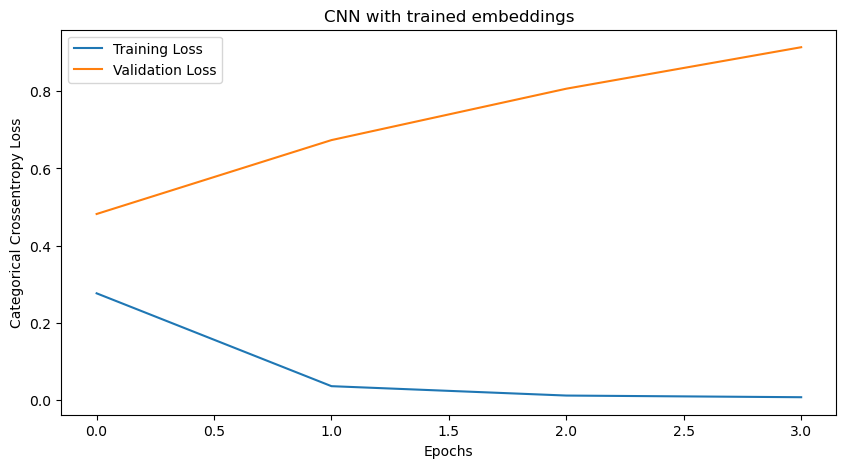

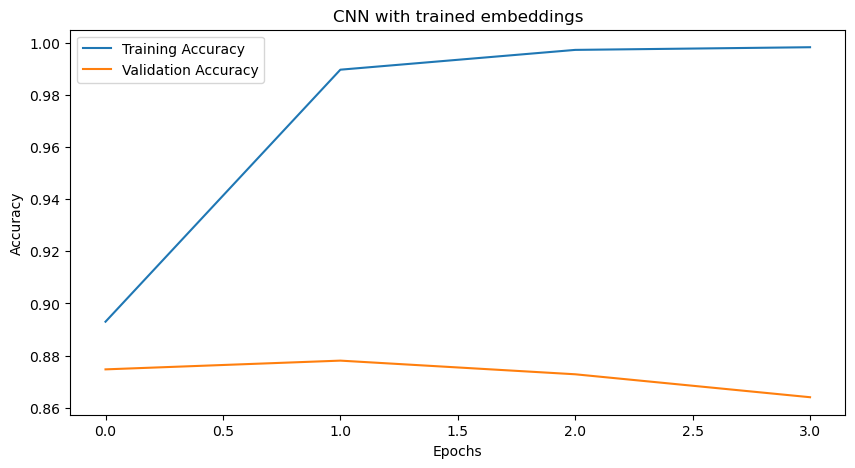

In [311]:
printResults(history2)
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 5s 35ms/step
              precision    recall  f1-score   support

        Hate       0.29      0.27      0.28       280
   Offensive       0.91      0.92      0.92      3715
     Neither       0.81      0.76      0.78       778

    accuracy                           0.86      4773
   macro avg       0.67      0.65      0.66      4773
weighted avg       0.86      0.86      0.86      4773

The confusion matrix:
[[  76  186   18]
 [ 163 3432  120]
 [  22  165  591]]


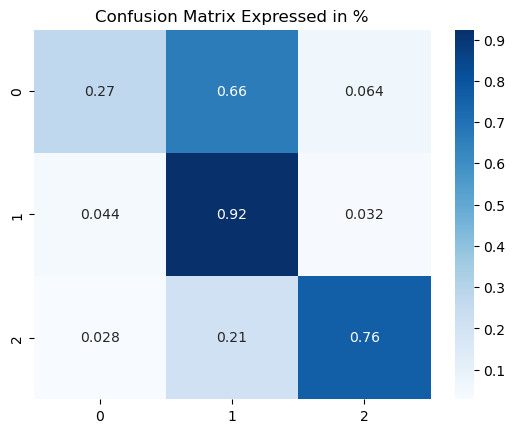

In [312]:
y_pred = model2.predict(X_test_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: Word2Vec

- https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/#Word2Vec_for_text_classification_example

Creating embedding layer

In [134]:
def createW2Vembedding(dimension, sg):
    #Training Word2Vec embedding layer using Skip grams
    sentences = [sentence.split() for sentence in X_train]
    w2v = Word2Vec(sentences, vector_size = dimension, sg=sg)

    #Creating the embedding weight matrix
    embedding_matrix = np.zeros((vocab_size,dimension))

    for word, i in tokenizer.word_index.items():
     if word in w2v.wv:
            embedding_matrix[i] = w2v.wv[word]

    return embedding_matrix


Simple CNN with word2Vec

In [135]:
def createCNNW2V1(num_filters=64,kernel_size=8, output_dimension=100, sg = 1):

    embedding_matrix = createW2Vembedding(output_dimension,sg)

    #Building model

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, input_length=max_length, weights = [embedding_matrix])(input)
    
    convolution = Conv1D(filters = num_filters, kernel_size = kernel_size, activation = 'relu')(embedding_layer)
    pooling = MaxPooling1D(pool_size=2)(convolution) #pooling to downsample feature extraction
    flatten = Flatten()(pooling)
    dense_1 = Dense(10, activation ='relu', kernel_regularizer=l2(0.01)) (flatten)
    dropout = Dropout(0.5)(dense_1)
    output = Dense(3, activation = "softmax") (dropout)

    model1 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.0001)
    model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model1.summary()

    return model1


early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

In [137]:
num_filters = 64
output_dimension = 100
kernel_size = 5
sg = 1

modelW2V1 = createCNNW2V1(num_filters,kernel_size, output_dimension, sg)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 127)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 127, 100)          1599200   
                                                                 
 conv1d_7 (Conv1D)           (None, 123, 64)           32064     
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 61, 64)            0         
 g1D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3904)              0         
                                                                 
 dense_14 (Dense)            (None, 10)                39050     
                                                           

In [139]:
history = model1.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=64, validation_data = (X_cv_tk, y_cv_encoded),callbacks=callbacks_list ) #, callbacks=callbacks_list


Epoch 1/10
519/519 [==============================] - 21s 41ms/step - loss: 0.8934 - accuracy: 0.5590 - val_loss: 0.5622 - val_accuracy: 0.8171
Epoch 2/10
519/519 [==============================] - 22s 43ms/step - loss: 0.5407 - accuracy: 0.8254 - val_loss: 0.5249 - val_accuracy: 0.8370
Epoch 3/10
519/519 [==============================] - 22s 43ms/step - loss: 0.4350 - accuracy: 0.8540 - val_loss: 0.5512 - val_accuracy: 0.8355
Epoch 4/10
519/519 [==============================] - 23s 45ms/step - loss: 0.4009 - accuracy: 0.8625 - val_loss: 0.5202 - val_accuracy: 0.8468
Epoch 5/10
519/519 [==============================] - 24s 46ms/step - loss: 0.3629 - accuracy: 0.8796 - val_loss: 0.5556 - val_accuracy: 0.8483
Epoch 5: early stopping


In [140]:
loss,acc = model1.evaluate(X_cv_tk, y_cv_encoded)


150/150 [==============================] - 1s 4ms/step - loss: 0.5556 - accuracy: 0.8483


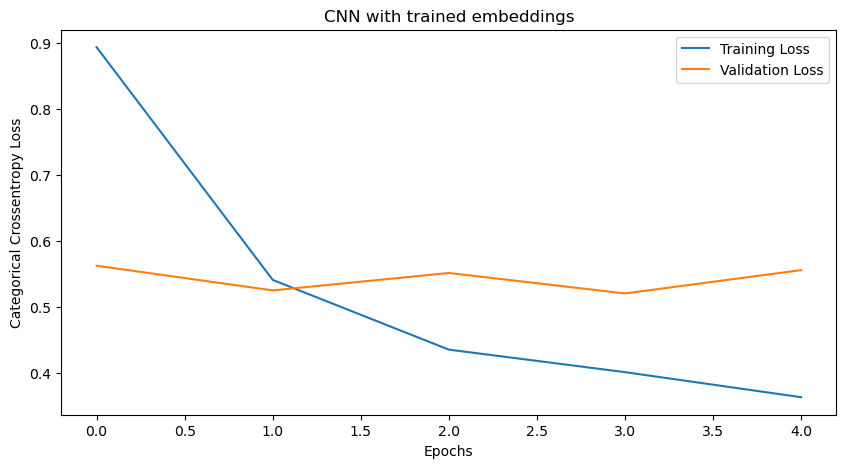

In [144]:
plotLossCurves(history)

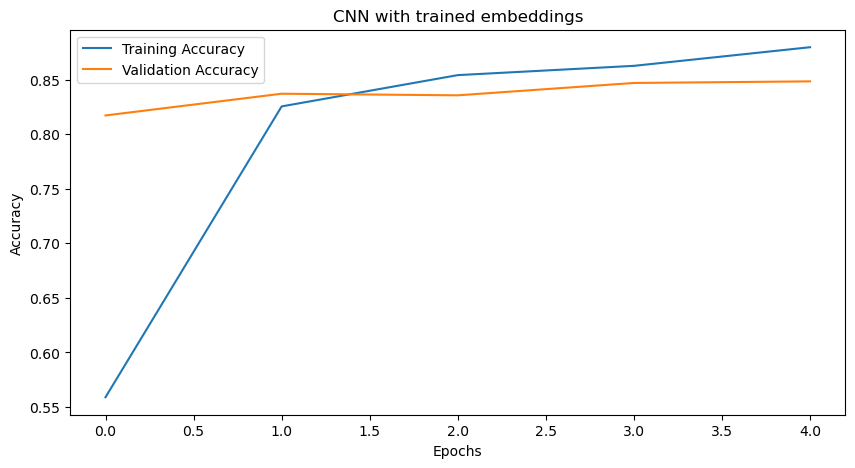

In [145]:
plotAccuracyCurves(history)

150/150 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

        Hate       0.28      0.26      0.27       269
   Offensive       0.90      0.93      0.91      3670
     Neither       0.79      0.67      0.73       834

    accuracy                           0.85      4773
   macro avg       0.66      0.62      0.64      4773
weighted avg       0.84      0.85      0.84      4773

The confusion matrix:
[[  71  172   26]
 [ 129 3418  123]
 [  51  223  560]]


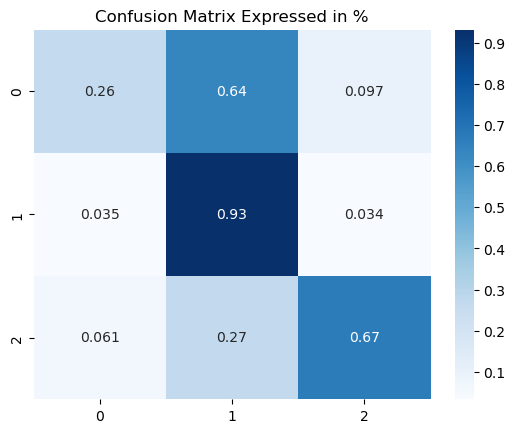

In [146]:
y_pred = model1.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)

printModelStats(predicted_categories, true_categories)

Yoon Kim CNN with word2Vec

In [158]:
kernel_sizes = [3,4,5]
convolutions = []
num_filters = 100
output_dimension = 300

def createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg):
    embedding_matrix = createW2Vembedding(output_dimension,sg)

    input = Input(shape=(max_length,), dtype="int32")
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=output_dimension, weights=[embedding_matrix], input_length=max_length)(input)

    convolutions = []
    for size in kernel_sizes:
        conv_layer = Conv1D(filters=num_filters, kernel_size=size, activation="relu",kernel_regularizer=l2(3))(embedding_layer) ##, kernel_regularizer=l2(3)
        pooling = MaxPooling1D(pool_size=3)(conv_layer)
        convolutions.append(pooling)
    
    conv_merged = concatenate(convolutions, axis=1)

    dropout = Dropout(0.5)(conv_merged)
    flatten = Flatten()(dropout)
    output = Dense(3, activation="softmax")(flatten)

    model2 = Model(inputs=input, outputs=output)
    optimizer = tensorflow.optimizers.Adam(lr=0.001)
    model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model2.summary()

    return model2

In [159]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1)
callbacks_list = [early_stopping]

model2 = createCNN2W2V(vocab_size, max_length, output_dimension, num_filters, kernel_sizes, sg=1)


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 127)]                0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 127, 300)             4797600   ['input_10[0][0]']            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 125, 100)             90100     ['embedding_8[0][0]']         
                                                                                                  
 conv1d_9 (Conv1D)           (None, 124, 100)             120100    ['embedding_8[0][0]']         
                                                                                            

In [160]:
history2 = model2.fit(X_train_tk, y_train_encoded, epochs =10, batch_size=50, validation_data = (X_cv_tk, y_cv_encoded), callbacks = callbacks_list)


Epoch 1/10
664/664 [==============================] - 139s 208ms/step - loss: 36.3193 - accuracy: 0.5943 - val_loss: 0.7639 - val_accuracy: 0.7431
Epoch 2/10
664/664 [==============================] - 135s 203ms/step - loss: 0.6242 - accuracy: 0.8241 - val_loss: 0.6924 - val_accuracy: 0.8165
Epoch 3/10
664/664 [==============================] - 139s 209ms/step - loss: 0.5290 - accuracy: 0.8836 - val_loss: 0.6420 - val_accuracy: 0.8401
Epoch 4/10
664/664 [==============================] - 132s 198ms/step - loss: 0.4792 - accuracy: 0.9103 - val_loss: 0.6382 - val_accuracy: 0.8487
Epoch 5/10
664/664 [==============================] - 132s 198ms/step - loss: 0.4411 - accuracy: 0.9270 - val_loss: 0.6929 - val_accuracy: 0.8496
Epoch 6/10
664/664 [==============================] - 129s 195ms/step - loss: 0.4224 - accuracy: 0.9334 - val_loss: 0.6655 - val_accuracy: 0.8487
Epoch 6: early stopping


In [161]:
printResults(history2)


,loss,accuracy,val_loss,val_accuracy
0,36.319305,0.594317,0.763874,0.743138
1,0.624159,0.824082,0.692450,0.816468
2,0.529002,0.883595,0.641961,0.840142
3,0.479200,0.910294,0.638214,0.848732
4,0.441069,0.926957,0.692923,0.849571
5,0.422425,0.933436,0.665514,0.848732


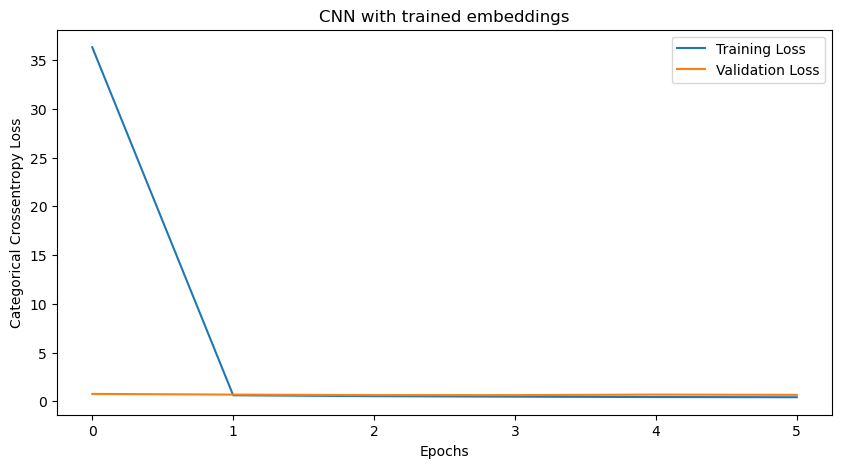

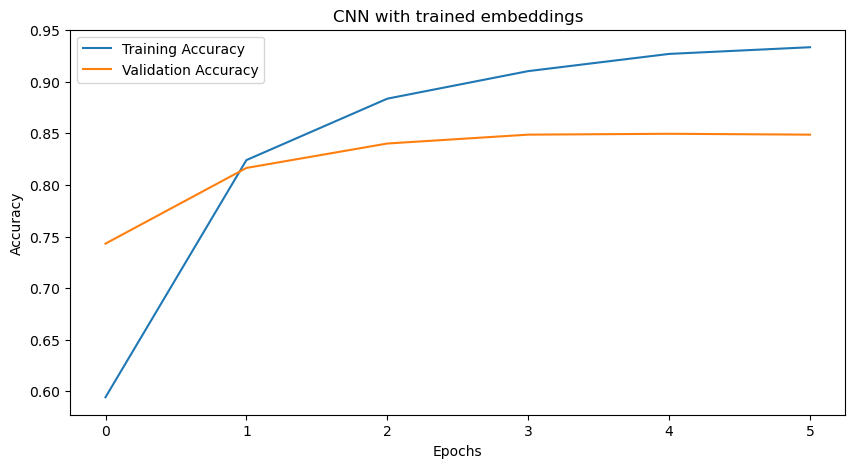

In [162]:
plotLossCurves(history2)
plotAccuracyCurves(history2)

150/150 [==============================] - 3s 19ms/step
              precision    recall  f1-score   support

        Hate       0.23      0.32      0.27       269
   Offensive       0.94      0.89      0.91      3670
     Neither       0.77      0.86      0.81       834

    accuracy                           0.85      4773
   macro avg       0.65      0.69      0.66      4773
weighted avg       0.87      0.85      0.86      4773

The confusion matrix:
[[  87  135   47]
 [ 256 3248  166]
 [  42   76  716]]


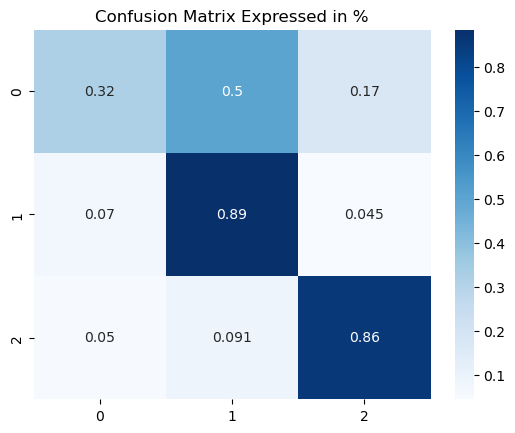

In [165]:
y_pred = model2.predict(X_cv_tk)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_cv_encoded,axis = 1)


printModelStats(predicted_categories, true_categories)

## CNN with pretrained embedding: glove

Creating glove embedding

In [ ]:
def createGloveEmbedding(dimension, sg):
    #Training Word2Vec embedding layer using Skip grams
    sentences = [sentence.split() for sentence in X_train]
    w2v = Word2Vec(sentences, vector_size = dimension, sg=sg)

    #Creating the embedding weight matrix
    embedding_matrix = np.zeros((vocab_size,dimension))

    for word, i in tokenizer.word_index.items():
     if word in w2v.wv:
            embedding_matrix[i] = w2v.wv[word]

    return embedding_matrix

## Parameter search